# Nino indices from HadISST data

:::{hint}
For a great introduction to Nino indices, see [the climate data guide](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni?utm_source=chatgpt.com)
:::

## Section 1: Introduction
- Python package imports and useful function definitions

In [55]:
# Import
import intake
import numpy as np
import xarray as xr
import nc_time_axis
import os
import matplotlib.pyplot as plt

In [31]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

In [32]:
# Set up your sratch folder path
username       = os.environ["USER"]
glade_scratch  = "/glade/derecho/scratch/" + username
print(glade_scratch)

/glade/derecho/scratch/harshah


In [49]:
#### Useful function ###
def area_mean(da):
    """
    Area-weighted mean over lat/lon using cos(lat) weighting.
    Assumes da has dims including lat, lon.
    """
    weights = np.cos(np.deg2rad(da["latitude"]))
    weights.name = "weights"
    return da.weighted(weights).mean(dim=("latitude", "longitude"), skipna=True)

def lon_to_360(da):
    """Ensure longitude is [0, 360) and sorted.""" 
    lon_name = "lon" if "lon" in da.coords else "longitude"
    lon = da[lon_name]
    lon360 = (lon % 360)   
    #The above logic is tricky for negative divisors or dividends and is not guaranteed to work in other programming languages
    #For more details, see https://en.wikipedia.org/wiki/Modulo
    da = da.assign_coords({lon_name: lon360}).sortby(lon_name)
    return da

In [47]:
##
def nino_index_series(sst, region):
    lat0, lat1 = region["latitude"]
    lon0, lon1 = region["longitude"]
    sub = sst.sel(latitude=slice(lat0, lat1), longitude=slice(lon0, lon1))
    return area_mean(sub)

## Section 2: Set up a Dask Cluster on Casper
- Setting up a dask cluster. You will need an NCAR HPC account to do this.

In [34]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-wk25',
    cores = 1,
    memory = '8GiB',
    processes = 1,
    local_directory = glade_scratch+'/dask/spill/',
    log_directory = glade_scratch + '/dask/logs/',
    resource_spec = 'select=1:ncpus=1:mem=8GB',
    queue = 'casper',
    walltime = '5:00:00',
    interface = 'ext'
)

In [35]:
# Create the client to load the Dashboard
client = Client(cluster)

In [36]:
n_workers = 5
cluster.scale(n_workers)
client.wait_for_workers(n_workers = n_workers)
cluster

PBSCluster(4a70a20c, 'tcp://128.117.208.101:39019', workers=5, threads=5, memory=40.00 GiB)

## Section 3: Data Loading and transforms
- Load HadISST data from GDEX using xarray
- For more details regarding the dataset. See, https://gdex.ucar.edu/datasets/d27703/#

In [37]:
import gzip
import tempfile

with gzip.open("/gdex/data/d277003/HadISST_sst.nc.gz", "rb") as f:
    raw = f.read()

with tempfile.NamedTemporaryFile(suffix=".nc") as tmp:
    tmp.write(raw)
    tmp.flush()
    ds = xr.open_dataset(tmp.name)

In [38]:
sst_raw = ds.sst
sst_raw

<xarray.DataArray 'sst' (time: 1872, latitude: 180, longitude: 360)> Size: 485MB
[121305600 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 15kB 1870-01-16T11:59:59.505615234 ... 2...
  * latitude   (latitude) float32 720B 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sst
    units:          C
    cell_methods:   time: lat: lon: mean

- Convert longitude from [-180,180) to [0,360)

In [39]:
sst = lon_to_360(sst_raw)
sst

<xarray.DataArray 'sst' (time: 1872, latitude: 180, longitude: 360)> Size: 485MB
[121305600 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 15kB 1870-01-16T11:59:59.505615234 ... 2...
  * latitude   (latitude) float32 720B 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 1kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sst
    units:          C
    cell_methods:   time: lat: lon: mean

## Section 4: Data Analysis
- Define the various nino regions and their spatial extent as a dictionary
- Compute area weighted spatial mean
- Make a quick plot of Nino indices
- Compute anomalies w.r.t to a baseline period
- Compute 6 month running mean and visualize El Nino events
- Optional: Compare with NOAA Nino index calculation

In [52]:
NINO_REGIONS = {
    "nino12": {"latitude": (0, -10),  "longitude": (270, 280)},  # 90W–80W
    "nino3":  {"latitude": (5, -5),   "longitude": (210, 270)},  # 150W–90W
    "nino34": {"latitude": (5, -5),   "longitude": (190, 240)},  # 170W–120W
    "nino4":  {"latitude": (5, -5),   "longitude": (160, 210)},  # 160E–150W
}

In [53]:
nino_raw = xr.Dataset({name: nino_index_series(sst, reg) for name, reg in NINO_REGIONS.items()})
nino_raw

<xarray.Dataset> Size: 45kB
Dimensions:  (time: 1872)
Coordinates:
  * time     (time) datetime64[ns] 15kB 1870-01-16T11:59:59.505615234 ... 202...
Data variables:
    nino12   (time) float32 7kB 23.22 25.36 26.08 25.34 ... 20.75 21.4 22.21
    nino3    (time) float32 7kB 24.2 25.14 26.35 26.69 ... 24.48 24.31 24.53
    nino34   (time) float32 7kB 25.54 25.54 26.42 26.95 ... 26.2 25.93 26.06
    nino4    (time) float32 7kB 27.78 26.93 27.28 27.5 ... 28.35 28.25 28.25

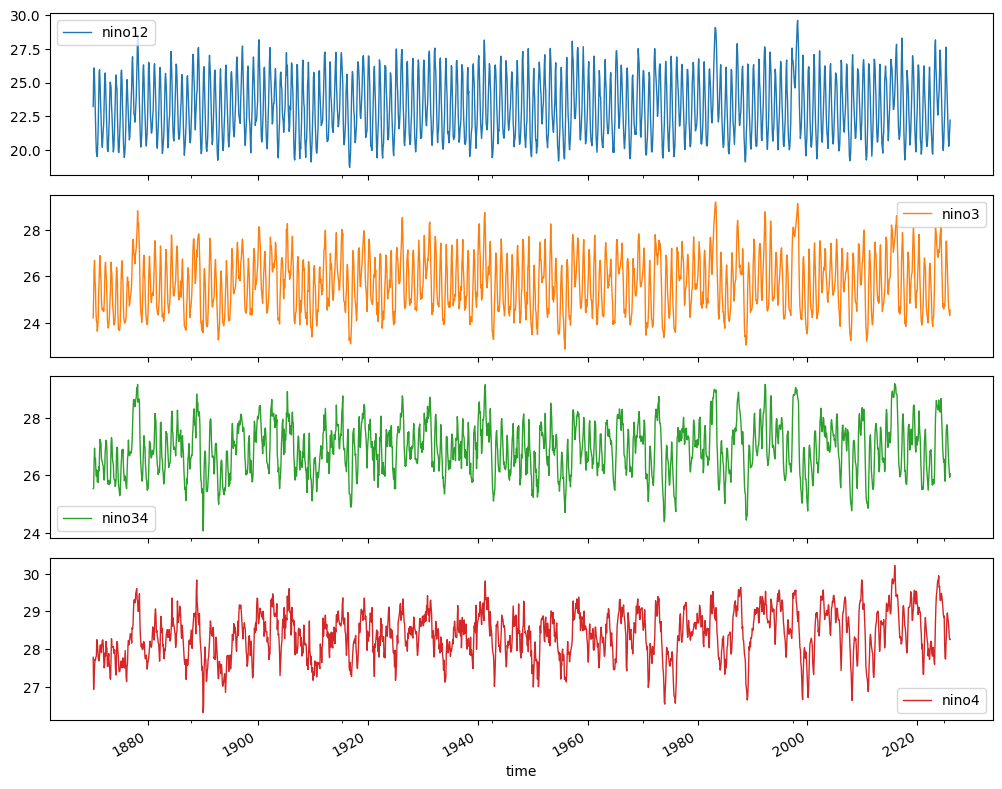

In [56]:
nino_raw.to_dataframe().plot(subplots=True, figsize=(10, 8), lw=1)
plt.tight_layout()
plt.show()

In [17]:
# %%time
# sst = xr.open_dataset('/gdex/data/d277003/HadISST_sst.nc.gz',engine='netcdf4')

### Compute Nino anomalies #####

## Acknowledgements
- Trenberth, Kevin & National Center for Atmospheric Research Staff (Eds). Last modified 2025-12-11 "The Climate Data Guide: Nino SST Indices (Nino 1+2, 3, 3.4, 4; ONI and TNI).” Retrieved from https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni on 2026-02-25.

In [57]:
cluster.close()